# A first hello world to Blackjax

Much of the code is adapted from https://blackjax-devs.github.io/blackjax/examples/quickstart.html

In [8]:
#!pip install edudat
import edudat
from edudat import load_data
df = load_data('sbp.csv', verbose=True)
df.head()

Using cached sbp.csv


,x,y
0,22,131
1,41,139
2,52,128
3,23,128
4,41,171


In [9]:
import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
import numpy as np
import blackjax

### Linear Regression

In [22]:
import jax.random as jrandom
key = jrandom.PRNGKey(0)
if False:
    import jax.numpy as jnp

    N = 5
    x = jnp.linspace(-2, 2, num=N)
    means = 2 * x + 1  # Calculate means based on your linear model
    y = means + jrandom.normal(key, shape=(N,))  # Generate standard normal data and shift by the means
    x,y
else:
    x = df['x'].values
    y = df['y'].values
    N = len(x)

#### Log Density, defineing the model

In [70]:

from jax.scipy.stats import norm, uniform

def logdensity_fn(theta):
    """
    Log density function for a linear regression model with uniform priors.
    
    Args:
    theta (array): An array of parameters [a, b, sigma].
    
    Returns:
    float: The log probability density of the model given the data.
    """
    # Extract parameters
    a, b, sigma = theta['theta']
    
    # Prior distributions for a, b, and sigma
    log_prior_a = norm.logpdf(a, 0, 10) # uniform prior on a between -100,100
    log_prior_b = norm.logpdf(b, 0, 10)
    log_prior_sigma = uniform.logpdf(sigma, 0.1, 100)
    #print(log_prior_a, jnp.exp(log_prior_b), log_prior_sigma)
    
    # The likelihood of the data given the model
    log_likelihood = jnp.sum(norm.logpdf(y, a * x + b, sigma))
    
    # Sum of log prior probabilities and the log likelihood
    log_posterior = log_prior_a + log_prior_b + log_prior_sigma + log_likelihood
    return log_posterior

initial_position = {"theta": jnp.array([0., 0., 1.])}
logdensity_fn(initial_position) # R Code -328281.9

Array(-328281.94, dtype=float32)

## Simple HMC Sampling

### Defining the sampler

Let's define a HMC sampler. We set the paramters of the sampler fixed. Note that in implementations like NUTS the step size and the number of steps are adapted during the warmup phase.

In [71]:
# HMC Sampler setup
step_size = 1e-3
num_integration_steps = 30
inverse_mass_matrix = np.ones(3)

# Define the HMC transition kernel
hmc = blackjax.hmc(logdensity_fn, step_size, inverse_mass_matrix,num_integration_steps)

When we start sampling more then just the initial position is required, also gradients need to be provied. 

In [72]:
# Initialize the sampler's state
initial_state = hmc.init(initial_position)
initial_state

HMCState(position={'theta': Array([0., 0., 1.], dtype=float32)}, logdensity=Array(-328281.94, dtype=float32), logdensity_grad={'theta': Array([220684.,   4575., 656448.], dtype=float32)})

In [73]:
hmc_kernel = jax.jit(hmc.step)

def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [74]:
%%time
rng_key, sample_key = jax.random.split(key)
states = inference_loop(sample_key, hmc_kernel, initial_state, 10_000)
mcmc_samples = states.position
states.logdensity
samples_hmc = mcmc_samples['theta']

CPU times: user 368 ms, sys: 70 ms, total: 438 ms
Wall time: 492 ms


### Nuts
NUTS is a dynamic algorithm: the number of integration steps is determined at runtime. We still need to specify a step size and a mass matrix:

In [75]:
inverse_mass_matrix = np.ones(3)
step_size = 1e-3
logdensity = lambda x: logdensity_fn(**x)

nuts = blackjax.nuts(logdensity_fn, step_size, inverse_mass_matrix)
initial_state = nuts.init(initial_position)
initial_state

HMCState(position={'theta': Array([0., 0., 1.], dtype=float32)}, logdensity=Array(-328281.94, dtype=float32), logdensity_grad={'theta': Array([220684.,   4575., 656448.], dtype=float32)})

In [76]:
%%time
rng_key, sample_key = jax.random.split(rng_key)
states = inference_loop(sample_key, nuts.step, initial_state, 4_000)

mcmc_samples_nuts = states.position['theta']

CPU times: user 2.47 s, sys: 120 ms, total: 2.59 s
Wall time: 2.84 s


In [77]:
#states

In [78]:
mcmc_samples_nuts

Array([[1.1140761e-01, 3.1927535e-03, 1.3276500e+00],
       [3.2669449e-01, 6.5558008e-03, 1.7751144e+00],
       [3.5848251e-01, 6.5790946e-03, 1.8199159e+00],
       ...,
       [2.1679115e+00, 3.0706789e+01, 3.0034973e+01],
       [2.1534982e+00, 2.9830521e+01, 3.0741049e+01],
       [2.2407045e+00, 2.9684967e+01, 3.0741926e+01]], dtype=float32)

### Finding the sampling parameters using Stan

Specifying the step size and inverse mass matrix is cumbersome. We can use Stan’s adaptation to get reasonable values for them so we have, in practice, no parameter to specify.

In [79]:
%%time

warmup = blackjax.window_adaptation(blackjax.nuts, logdensity_fn)
rng_key, warmup_key, sample_key = jax.random.split(rng_key, 3)
(state, parameters), _ = warmup.run(warmup_key, initial_position, num_steps=1000)
parameters

CPU times: user 1.16 s, sys: 107 ms, total: 1.27 s
Wall time: 1.4 s


{'step_size': Array(0.32719117, dtype=float32, weak_type=True),
 'inverse_mass_matrix': Array([5.1943649e-02, 1.0941637e+02, 2.3857704e+01], dtype=float32)}

In [80]:
%%time

kernel = blackjax.nuts(logdensity_fn, **parameters).step
states = inference_loop(sample_key, kernel, state, 4000)

mcmc_samples = states.position
nuts_stan_init = states.position['theta']

CPU times: user 882 ms, sys: 84.8 ms, total: 967 ms
Wall time: 1.05 s


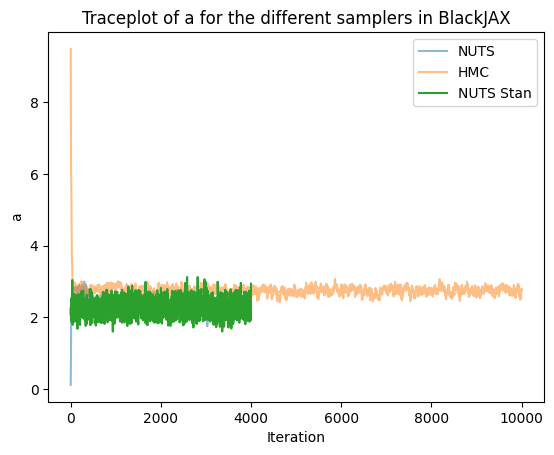

In [81]:
from matplotlib import pyplot as plt
plt.plot(mcmc_samples_nuts[:,0], alpha=0.5, label='NUTS')
plt.plot(samples_hmc[:,0], label='HMC',alpha=0.5)
plt.plot(nuts_stan_init[:,0], label='NUTS Stan')
plt.xlabel('Iteration')
plt.ylabel('a')
plt.title('Traceplot of a for the different samplers in BlackJAX')
plt.legend()

In [93]:
nuts_stan_init.mean(axis=0), np.median(nuts_stan_init, axis=0) #
samples_hmc.mean(axis=0), np.median(samples_hmc, axis=0) #
mcmc_samples_nuts.mean(axis=0), np.median(mcmc_samples_nuts, axis=0) #

# Make table
import pandas as pd
df = pd.DataFrame(
    {'HMC': samples_hmc.mean(axis=0), 
     'NUTS': mcmc_samples_nuts.mean(axis=0), 
     'NUTS Stan': nuts_stan_init.mean(axis=0),
     'R Code Stan': (2.26, 27.42, 29.08)})
df

,HMC,NUTS,NUTS Stan,R Code Stan
0,2.756658,2.371732,2.263189,2.26
1,2.215259,21.575661,27.484911,27.42
2,24.947882,28.749268,29.151072,29.08


#### Calculation of the effective sample sizes with arviz

Unfortunatly the arviz does take the output of the blackjax sampler. We need to convert the output to a format that arviz can handle. 

In [82]:
import numpy as np
import arviz as az

def convert_samples_to_dataset(samples):
    """
    Convert samples to an ArviZ InferenceData object.
    The samples must be in a 3D array with dimensions (chains, draws, parameters).
    """
    # Ensure the samples are in a 3D array
    if samples.ndim == 2:
        samples = samples[np.newaxis, :]

    # Convert the samples to an array and then to an ArviZ InferenceData object
    samples = np.array(samples)
    d_az = az.convert_to_dataset(samples)

    return d_az

In [83]:
import numpy as np
import pandas as pd
import arviz as az

def calculate_ess(samples, sampler_name):
    ess_result = az.ess(convert_samples_to_dataset(samples))
     # Properly extract the numerical ESS values from the result
    ess_values = ess_result.to_dataframe().squeeze().values
    ess_series = pd.Series(ess_values, name=sampler_name)
    return ess_series

# Calculating ESS for each sampler
ess_hmc = calculate_ess(samples_hmc, 'HMC')
ess_nuts = calculate_ess(mcmc_samples_nuts, 'NUTS')
ess_nuts_stan = calculate_ess(nuts_stan_init, 'NUTS Stan')

# Combine the results into a single DataFrame
ess_df = pd.DataFrame({'HMC': ess_hmc, 'NUTS': ess_nuts, 'NUTS Stan': ess_nuts_stan})
ess_df.index.name = 'Parameter'
display('ESS', ess_df)


'ESS'

,HMC,NUTS,NUTS Stan
Parameter,,,
0,182.793362,19.516408,1018.500831
1,5.042875,10.995289,966.788426
2,1.832990,34.089027,1218.398209


array([[<Axes: title={'center': 'x\n0'}>,
        <Axes: title={'center': 'x\n0'}>],
       [<Axes: title={'center': 'x\n1'}>,
        <Axes: title={'center': 'x\n1'}>],
       [<Axes: title={'center': 'x\n2'}>,
        <Axes: title={'center': 'x\n2'}>]], dtype=object)

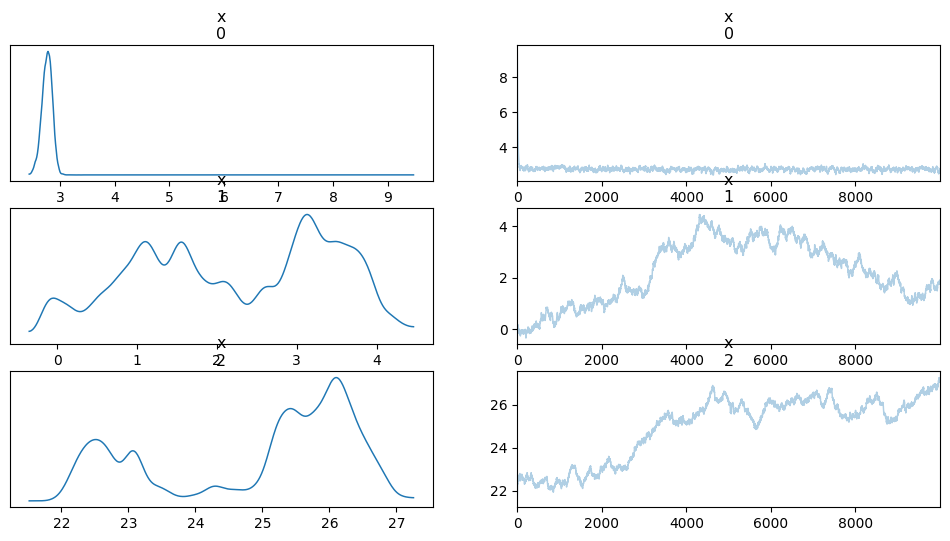

In [94]:
mcmc_sample = convert_samples_to_dataset(samples_hmc)#convert_samples_to_dataset(nuts_stan_init)
az.plot_trace(mcmc_sample, compact=False)

(Array([ 2.2631886, 27.484911 , 29.151072 ], dtype=float32),
 array([ 2.2569969, 27.736748 , 28.683403 ], dtype=float32))